In [4]:
import gpxpy
import gpxpy.gpx

import geopy
from geopy import distance

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [5]:
coords_1 = (47.238047, 7.659688)
coords_2 = (47.238050, 7.659700)

distance.distance(coords_1, coords_2).m
# (lat, lon) <- this is important

0.9678909151315687

### load & create metrics

In [32]:
gpx_file = open('data/activity_6321809225.gpx', 'r') # 23.02.2021

In [ ]:
gpx_file = open('data/activity_6374486103.gpx', 'r') # 04.03.2021
#gpx_file = open('data/test.gpx', 'r') # control file. must not be identical to activity_6374486103.gpx

In [27]:
gpx_file = open('data/activity_6403188314.gpx', 'r') # 09.03.2021

In [22]:
gpx_file = open('data/activity_6451992907.gpx', 'r') # 18.03.2021

In [12]:
gpx_file = open('data/activity_8215567101.gpx', 'r') # 31.01.2022

In [33]:
gpx = gpxpy.parse(gpx_file)

cols = ['time', 'lat', 'lon', 'ele']
lst = []


for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lst.append([point.time,
                       point.latitude,
                       point.longitude,
                       point.elevation])
            #print('Point at ({0},{1}) -> {2} -> {3}'.format(point.latitude, point.longitude, point.elevation, point.time))
            
df = pd.DataFrame(lst, columns = cols)

df.loc[0, 'distance'] = 0
df.loc[0, 'timedelta'] = 1
df.loc[0, 'timefromstart'] = 0
for i in range(1, len(df)):
    coords_1 = (df.loc[i-1, 'lat'], df.loc[i-1, 'lon'])
    coords_2 = (df.loc[i, 'lat'], df.loc[i, 'lon'])
    df.loc[i, 'distance'] = geopy.distance.distance(coords_1, coords_2).m
    
    df.loc[i, 'timedelta'] = (df.loc[i, 'time'] - df.loc[i-1, 'time']).seconds
    
    df.loc[i, 'timefromstart'] = (df.loc[i - 1, 'timefromstart'] + df.loc[i, 'timedelta'])

df['speed'] = df.distance/df.timedelta*3.6
df['timedelta'] = df.timedelta.astype('int')
df['speed_ma'] = df['speed'].rolling(5).mean()
df

,time,lat,lon,ele,distance,timedelta,timefromstart,speed,speed_ma
0,2021-02-23 17:45:07+00:00,47.236479,7.655275,419.799988,0.000000,1,0.0,0.000000,NaN
1,2021-02-23 17:45:08+00:00,47.236478,7.655275,419.799988,0.074549,1,1.0,0.268376,NaN
2,2021-02-23 17:45:09+00:00,47.236478,7.655275,419.799988,0.009319,1,2.0,0.033547,NaN
3,2021-02-23 17:45:13+00:00,47.236540,7.655183,419.799988,9.780968,4,6.0,8.802871,NaN
4,2021-02-23 17:45:15+00:00,47.236603,7.655127,419.600006,8.169059,2,8.0,14.704307,4.761820
...,...,...,...,...,...,...,...,...,...
831,2021-02-23 18:43:31+00:00,47.232893,7.655018,423.399994,15.771331,5,3504.0,11.355359,11.774091
832,2021-02-23 18:43:36+00:00,47.233045,7.655128,422.799988,18.835457,5,3509.0,13.561529,11.643023
833,2021-02-23 18:43:38+00:00,47.233113,7.655166,422.600006,8.070407,2,3511.0,14.526733,12.153219
834,2021-02-23 18:43:39+00:00,47.233140,7.655182,422.399994,3.275242,1,3512.0,11.790872,12.281830


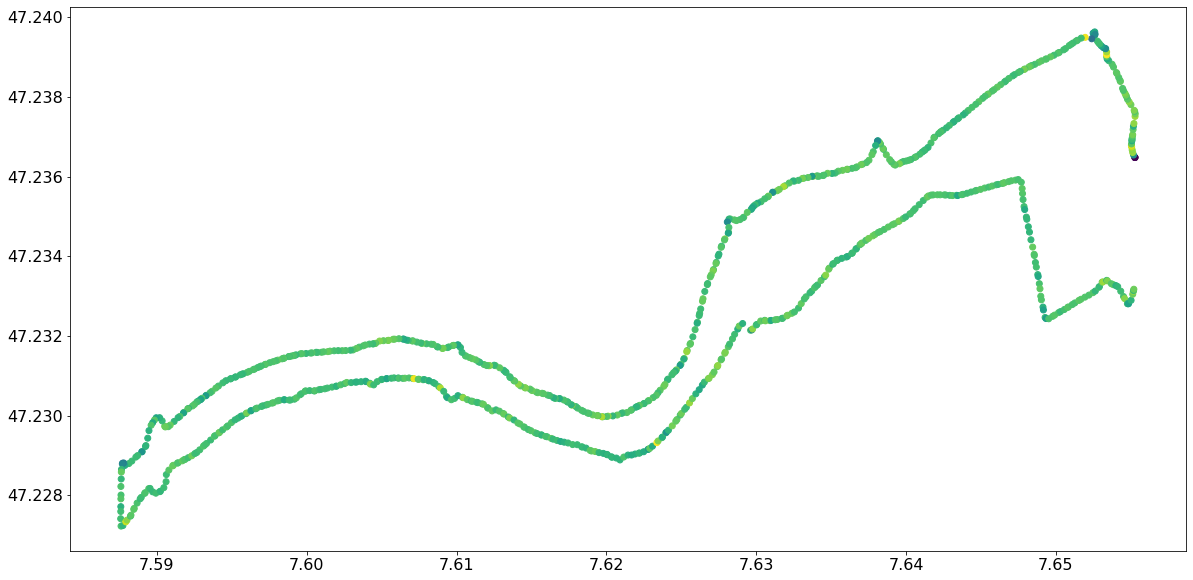

In [34]:
ax = plt.figure(figsize = (20, 10))

plt.scatter(df.lon, df.lat, c = df.speed)

plt.show()

### speed

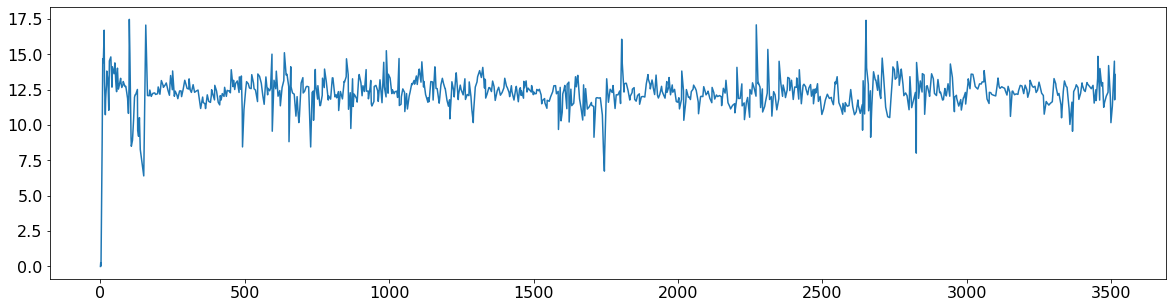

In [35]:
x = df['timefromstart']
y = df['speed']


fig = plt.figure(figsize = (20,5))
ax = plt.axes()

ax.plot(x,y)
plt.show()

### number of sprints

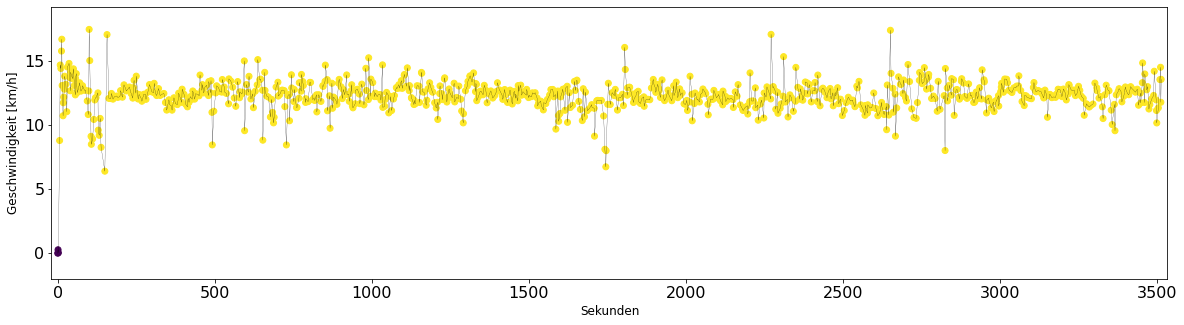

0 Sprints während total 0 Sekunden
Maximalgeschwindigkeit: 17.49km/h


In [36]:
def plot_by_zone(df):

    # classify zone
    # 0 -> standing (speed below 1)
    # 1 -> walking (speed 1...maxwalk)
    # 2 -> jogging (speed maxwalk..maxjog)
    # 3 -> sprinting (speed above 15)

    maxwalk = 5
    maxjog = 20
    for i in range(0, len(df)):
        if df.loc[i, 'speed'] < 1:
            df.loc[i, 'zone'] = 0
        elif df.loc[i, 'speed'] < maxwalk:
            df.loc[i, 'zone'] = 1
        elif df.loc[i, 'speed'] < maxjog:
            df.loc[i, 'zone'] = 2
        else:
            df.loc[i, 'zone'] = 3

    count = 0
    flag = 0
    for i in range(0, len(df)):
        if (df.loc[i, 'speed'] > maxjog) & (flag == 0):
            count += 1
            flag = 1
        if (df.loc[i, 'speed'] < maxjog) & (flag == 1):
            flag = 0

    time_in_sprint = df[df['speed'] > maxjog]['timedelta'].sum()

    x = df['timefromstart']
    y = df['speed']


    fig = plt.figure(figsize = (20,5))
    ax = plt.axes()

    ax.scatter(data = df,
                         x = 'timefromstart',
                         y = 'speed',
                         c = 'zone')
    ax.plot(x, y, color = 'black', linewidth=0.2)

    plt.xlabel('Sekunden', size = 12)
    plt.ylabel('Geschwindigkeit [km/h]', size = 12)
    plt.ylim(-2,df['speed'].max()*1.1)
    plt.xlim(-20,df['timefromstart'].max() + 20)
    plt.show()

    print('{0} Sprints während total {1} Sekunden'.format(count, time_in_sprint))
    print('Maximalgeschwindigkeit: {:.2f}km/h'.format(df['speed'].max()))

plot_by_zone(df)

### distance & time per zone

In [42]:
df_zones

,distance,timedelta
zone,,
0.0,0.083868,3
2.0,12004.623898,3511


In [41]:
df_zones = df.groupby('zone').sum().drop(columns = ['lat', 'lon', 'ele', 'timefromstart', 'speed','speed_ma'])
labels = ['Zone 0 -> Stillstand', 'Zone 1 -> Gehen', 'Zone 2 -> Jogging', 'Zone 3 -> Sprint']
plt.rcParams.update({'font.size': 16})
cols = ['mediumseagreen', 'royalblue', 'sandybrown', 'indianred']

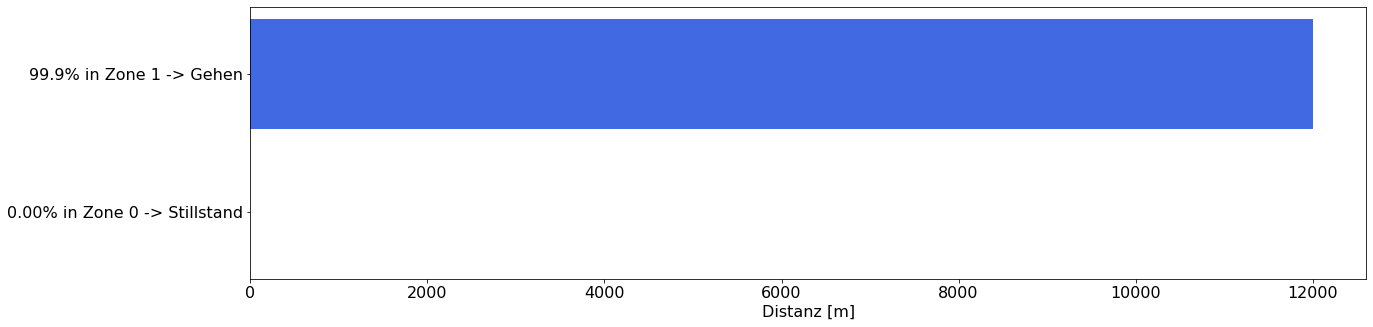

In [38]:
y = 'distance'

fig = plt.figure(figsize = (20,5))
ax = plt.axes()

total = df_zones[y].sum()

percentages = df_zones[y]/total
labels_perc = [str(y*100)[0:4] + '% in ' + x for x, y in zip(labels, list(percentages))]

ax.barh(labels_perc, df_zones['distance'], color = cols)

plt.xlabel('Distanz [m]')
plt.show()

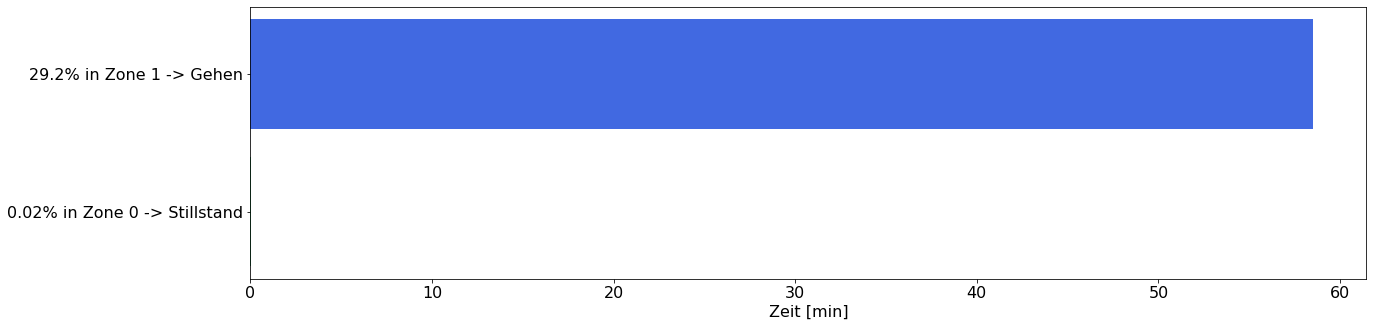

In [39]:
y = 'timedelta'

fig = plt.figure(figsize = (20,5))
ax = plt.axes()

percentages = df_zones[y]/total
labels_perc = [str(y*100)[0:4] + '% in ' + x for x, y in zip(labels, list(percentages))]

ax.barh(labels_perc, df_zones[y]/60, color = cols)

plt.xlabel('Zeit [min]')
plt.show()

### special analysis

In [94]:
df_chase = df[(df['timefromstart'] > 630) & (df['timefromstart'] < 1275)]
ind_new = np.arange(0, len(df_chase))
df_chase = df_chase.set_index(ind_new)
df_chase['timefromstart'] = df_chase['timefromstart'] - df_chase.loc[0, 'timefromstart']

In [95]:
chase_dist = df_chase.distance.sum()/1000
chase_time = df_chase.timefromstart.max()/60
chase_time_min = int(chase_time/chase_dist)
chase_time_sec = int((chase_time/chase_dist - chase_time_min)*60)

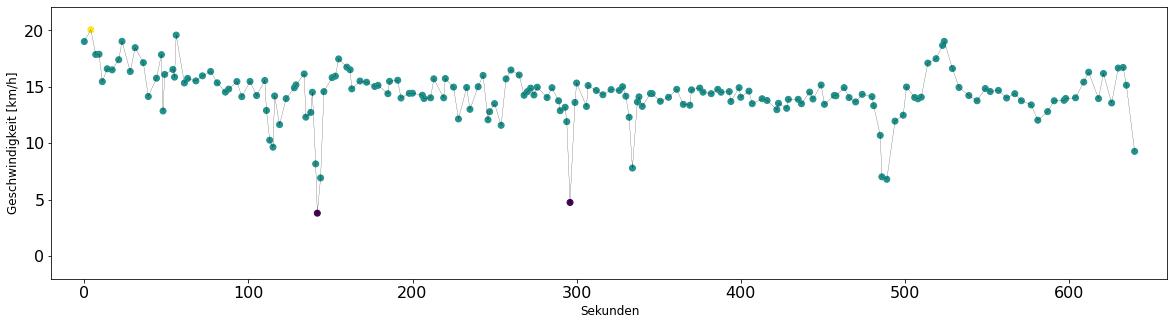

1 Sprints während total 4 Sekunden
Maximalgeschwindigkeit: 20.06km/h
2.59 Kilometer in 10.67 Minuten. Pace = 4min 7sec


In [101]:
plot_by_zone(df_chase)
print('{:.2f} Kilometer in {:.2f} Minuten. Pace = {}min {}sec'.format(chase_dist, chase_time, chase_time_min, chase_time_sec))